<a href="https://colab.research.google.com/github/renecotyfanboy/JAXtronomy-tutorials/blob/main/cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D model fitting with `JAX` & `numpyro`

In this notebook we will show you how to solve a Bayesian inference problem using numpyro and JAX. We will focus on fitting a surface brightness model to an X-ray image of the galaxy cluster Abell 3266, using the early data release of eRosita. Please note that solving a Bayesian inference problem using MCMC usually takes a long time. To keep the timescale small, we resample the image to an absurdly small number of pixels to make the MCMC run faster. A more precise example can be found [here](https://renecotyfanboy.github.io/clusterXrayFluctuation/examples/mean_model/).

It is divided in 4 sections:

1. Data downloading and pre-treatment
2. Description of the model
3. Maximum likelihood estimation
4. Full Bayesian inference

# Import and data loading

In [1]:
!pip install cmasher numpyro chainconsumer jaxopt

In [2]:
!gdown 1LGHpPp0KXnCRDtJD2alvyvaiNaJ7eDT3 # A3266 image from E-Rosita public data
!gdown 1PLvzBbae0EANWBLggqgwPDwecsx7sxLF # A3266 exposure map

Downloading...
From (original): https://drive.google.com/uc?id=1LGHpPp0KXnCRDtJD2alvyvaiNaJ7eDT3
From (redirected): https://drive.google.com/uc?id=1LGHpPp0KXnCRDtJD2alvyvaiNaJ7eDT3&confirm=t&uuid=8efd646d-bddf-42b8-a596-1312e2b48851
To: /content/a3266_img_erosita.fits
100% 197M/197M [00:02<00:00, 74.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PLvzBbae0EANWBLggqgwPDwecsx7sxLF
To: /content/a3266_exp_erosita.fits
100% 42.5M/42.5M [00:00<00:00, 126MB/s]


In [3]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import warnings
import cmasher as cmr
import numpyro.distributions as dist
from astropy.nddata import block_reduce
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.wcs import WCS
from jax import random
from jax.random import PRNGKey
from numpyro.infer import MCMC, NUTS

# Data from eRosita EDR



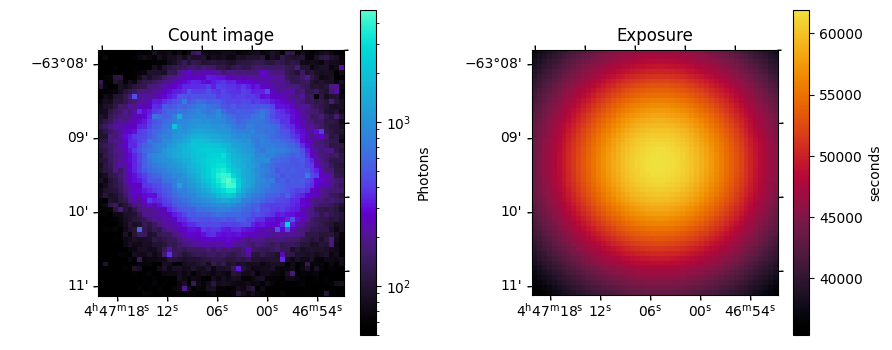

In [4]:
# Load the data

img_uncropped = fits.getdata('a3266_img_erosita.fits')
exp_uncropped = fits.getdata('a3266_exp_erosita.fits')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wcs = WCS(header = fits.getheader('a3266_img_erosita.fits'), relax=True)

# Crop to the central parts

size = 200
x_min, y_min = 1620-size, 1620-size
x_max, y_max = 1620+size, 1620+size
img = img_uncropped[x_min:x_max+1, y_min:y_max+1]
exp = exp_uncropped[x_min:x_max+1, y_min:y_max+1]

# Rebin to lower number

img = block_reduce(img, 8, np.sum)
exp = block_reduce(exp, 8, np.mean)

# Display the data

plt.figure(figsize=(9,4))
ax = plt.subplot(121, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(img, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Count image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(122, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(exp, cmap=cmr.ember)
plt.title('Exposure')
plt.colorbar(mappable=mappable, label='seconds')
plt.tight_layout()

# Surface Brightness Model

Here are the E-Rosita calibration images for the A3266 cluster of galaxies. For this example, we will determine an average emission model for this cluster. We choose the classical $\beta$-model [(Cavaliere & Fusco-Femiano, 1976)](https://ui-adsabs-harvard-edu.insu.bib.cnrs.fr/abs/1976A&A....49..137C/abstract) for this exercise. The $\beta$-model can describe either the surface brightness or the underlying density of the cluster, assuming spherical symmetry. It is expressed with the following equation :
$$
S_X(r) = S_{X,0} \left(1 + \left(\frac{r}{r_c}\right)^2\right)^{-\frac{3\beta}{2}}
$$

In the following cell, we show an implementation of this model which is numpy & JAX friendly, and plot the profile to show its shape.

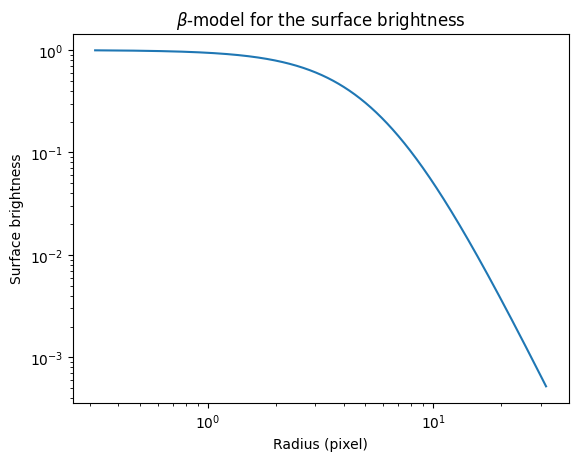

In [5]:
@jax.jit
def beta_model(r, **kwargs):
    """
    Implementation of a surface brightness beta-model
    """

    norm = jnp.float64(kwargs.get('norm', 1))
    r_c = jnp.float64(kwargs.get('r_c', 2*3.))
    beta = jnp.float64(kwargs.get('beta', 3/2))

    return norm*(1 + (r/r_c)**2)**(-3*beta/2)

# Plotting an example profile

r = jnp.logspace(-0.5, 1.5, 1000)

figure = plt.figure()
plt.plot(r, beta_model(r))
plt.title(r'$\beta$-model for the surface brightness')
plt.xlabel('Radius (pixel)')
plt.ylabel('Surface brightness')
plt.loglog();

This kind of model is often used either as a density model or a surface brightness model. For the sake of simplicity, we will fit a surface brightness model here using Bayesian inference. To do so, we must relate our model to the observable, which is here the number of counts in each pixel of the image. One can write the expected counts in each pixel as follows :

$$ \text{Counts} = S_X \times \text{Exposure} $$

In the following cell, we show an implementation for this model and how it can accurately describe the expected emission from the cluster.

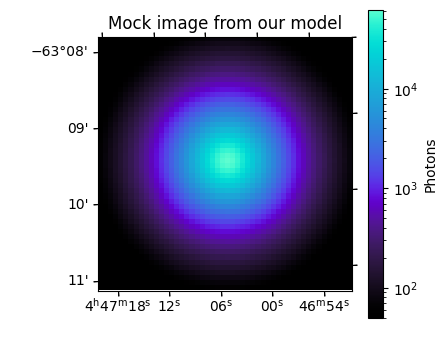

In [6]:
@jax.jit
def counts(exp, **kwargs):

    x, y = jnp.indices(exp.shape)

    x_c = jnp.float64(kwargs.get('x_c', exp.shape[0]//2))
    y_c = jnp.float64(kwargs.get('y_c', exp.shape[1]//2))

    r = jnp.hypot(x-x_c,y-y_c)

    sb = beta_model(r, **kwargs)

    return sb * jnp.float64(exp)


plt.figure(figsize=(9,4))
ax = plt.subplot(121, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(counts(exp), norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Mock image from our model')
plt.colorbar(mappable=mappable, label='Photons');

# Maximum likelihood estimation

In [7]:
import jaxopt

init_params = {
        'x_c': jnp.asarray(25.),
        'y_c': jnp.asarray(25.),
        'norm': jnp.asarray(0.05),
        'r_c': jnp.asarray(10.),
        'beta': jnp.asarray(3/2),
        }

low = {
        'x_c': jnp.asarray(15.),
        'y_c': jnp.asarray(15.),
        'norm': jnp.asarray(0.),
        'r_c': jnp.asarray(5.),
        'beta': jnp.asarray(0.),
        }

high = {
        'x_c': jnp.asarray(35.),
        'y_c': jnp.asarray(35.),
        'norm': jnp.asarray(1.),
        'r_c': jnp.asarray(20.),
        'beta': jnp.asarray(2.),
        }

@jax.jit
def loss(params):
    return -dist.Poisson(counts(exp, **params)).log_prob(img).sum()

solver = jaxopt.ScipyBoundedMinimize(fun=loss)
res = solver.run(init_params, bounds=(low, high))

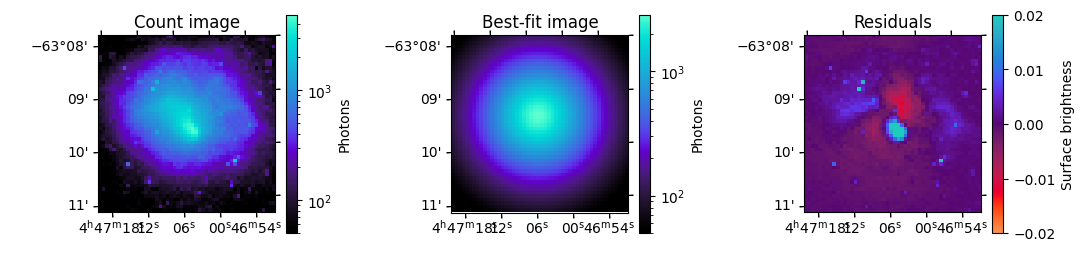

In [8]:
best_fit = res.params
best_fit_image = counts(exp, **best_fit)

plt.figure(figsize=(11,3))
ax = plt.subplot(131, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(img, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Count image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(132, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(best_fit_image, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Best-fit image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(133, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow((img-best_fit_image)/exp, cmap=cmr.guppy, vmin=-0.02, vmax=0.02)
plt.title('Residuals')
plt.colorbar(mappable=mappable, label='Surface brightness')
plt.tight_layout()

# Bayesian approach

## Running the MCMC

In [9]:
def model(img, exp):

    prior = {
        'x_c': numpyro.sample('x_c', dist.Normal(img.shape[0]/2, 2)),
        'y_c': numpyro.sample('y_c', dist.Normal(img.shape[1]/2, 2)),
        'norm': numpyro.sample('norm', dist.LogUniform(1e-4, 1e-1)),
        'r_c': numpyro.sample('r_c', dist.Uniform(0, 20)),
        'beta': numpyro.sample('beta', dist.Uniform(0., 2.))
    }

    numpyro.sample('likelihood',
                    dist.Poisson(counts(exp, **prior)),
                    obs=img)

In [10]:
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro import handlers

reparametrized_model = handlers.reparam(
    model,
     {
         "norm": TransformReparam(),
         "x_c": LocScaleReparam(),
         "y_c": LocScaleReparam()
    }
)

In [11]:
from numpyro.infer.initialization import init_to_median

kernel = NUTS(reparametrized_model, dense_mass=True, init_strategy=init_to_median)

mcmc = MCMC(
    kernel,
    num_warmup=5000,
    num_samples=5000,
    num_chains=4,
)

In [12]:
mcmc.run(PRNGKey(42), img, exp)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
posterior_samples = mcmc.get_samples(group_by_chain=True)

## Sanity checks

We compute some values to check wether or not our chains went nuts. In particular:

- $\hat{R}$ should be lower than $\lesssim 1.01$
- $ESS$ should be higher than $\gtrsim 400$

See e.g. [Vehtari & al.](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-2/Rank-Normalization-Folding-and-Localization--An-Improved-R%CB%86-for/10.1214/20-BA1221.full)

In [14]:
import arviz as az
import matplotlib.pyplot as plt

inference_data = az.from_numpyro(mcmc)
az.summary(inference_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.912,0.004,0.905,0.919,0.0,0.0,22915.0,13808.0,1.0
norm,0.046,0.000,0.046,0.046,0.0,0.0,24049.0,14514.0,1.0
norm_base,-3.080,0.003,-3.086,-3.074,0.0,0.0,24049.0,14514.0,1.0
r_c,8.814,0.046,8.730,8.905,0.0,0.0,22793.0,13814.0,1.0
x_c,26.579,0.011,26.558,26.600,0.0,0.0,22490.0,13918.0,1.0
x_c_decentered,13.617,0.008,13.602,13.631,0.0,0.0,22490.0,13918.0,1.0
y_c,23.816,0.011,23.796,23.837,0.0,0.0,22384.0,14235.0,1.0
y_c_decentered,11.663,0.008,11.649,11.677,0.0,0.0,22384.0,14235.0,1.0


## Display the results

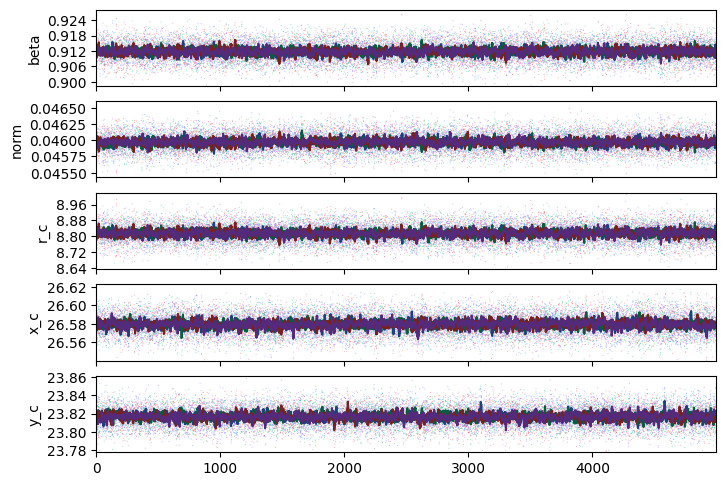

In [15]:
from chainconsumer import ChainConsumer, Chain, PlotConfig
import pandas as pd

c = ChainConsumer()

for i in range(4):

    # Filter the parameters of interest
    dict_of_samples = {
        key:value[i, ...] for key, value in posterior_samples.items()
        if not (key.endswith("_base") or key.endswith("_decentered"))
    }

    chain = Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name=f"Chain {i}")
    c.add_chain(chain)

c.set_plot_config(PlotConfig(kde=True, shade_alpha=0.3))

fig = c.plotter.plot_walks(convolve=10, plot_weights=False)

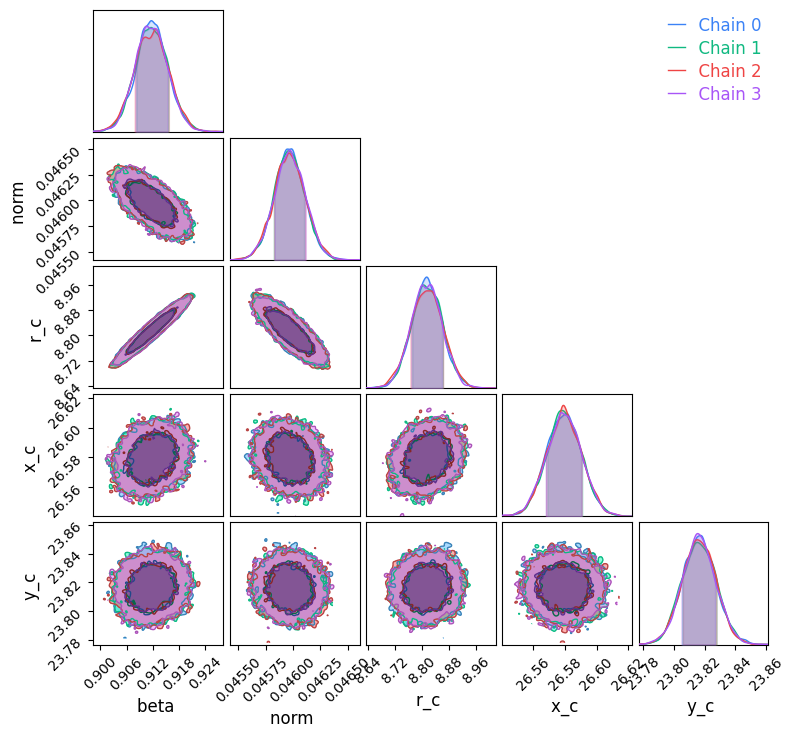

In [16]:
fig = c.plotter.plot(figsize=8);

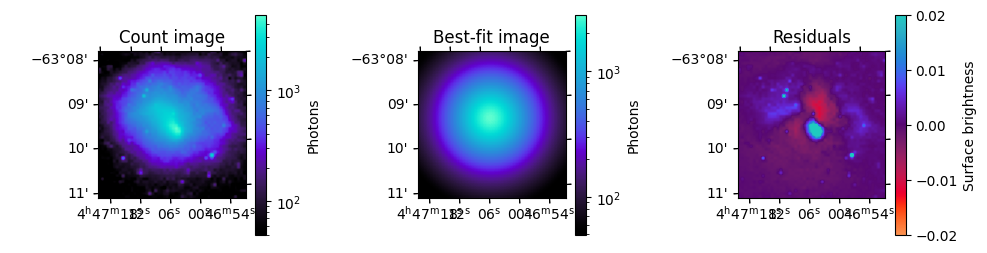

In [17]:
# Fancy line to flatten the parameters and evaluate the image using all our samples
images = jax.vmap(lambda p : counts(exp, **p))(jax.tree.map(jnp.ravel, posterior_samples))
lower_image, median_image, upper_image = np.percentile(images, [16, 50, 84], axis=0)
median_residual = (img - median_image)/exp

plt.figure(figsize=(10,3))
ax = plt.subplot(131, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(img, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Count image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(132, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(median_image, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Best-fit image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(133, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(median_residual, cmap=cmr.guppy, vmin=-0.02, vmax=0.02)
plt.title('Residuals')
plt.colorbar(mappable=mappable, label='Surface brightness')
plt.tight_layout()